In [13]:
# ============================================================================
# STEP 2: IMPORT REQUIRED LIBRARIES
# ============================================================================

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Natural Language Processing
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Machine learning preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.cluster import KMeans
from sklearn.calibration import CalibratedClassifierCV

# Model evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# Handle imbalanced data
from imblearn.over_sampling import SMOTE

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Model persistence
import joblib

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data files
print("[INFO] Downloading NLTK resources...")
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('omw-1.4', quiet=True)

print("[SUCCESS] All libraries imported successfully!")

[INFO] Downloading NLTK resources...
[SUCCESS] All libraries imported successfully!


In [14]:
# ============================================================================
# STEP 3: UPLOAD DATASETS
# ============================================================================

from google.colab import files

print("="*80)
print("DATASET UPLOAD SECTION")
print("="*80)
print("\n[INFO] Please upload the following files:")
print("  1. Constraint_English_Train.csv")
print("  2. Constraint_English_Test.csv")
print("  3. Constraint_English_Val.csv")
print("  4. news.csv")
print("\nClick 'Choose Files' button below and select all files.")
print("="*80)

uploaded = files.upload()

print("\n[SUCCESS] Files uploaded successfully!")
print(f"[INFO] Uploaded files: {list(uploaded.keys())}")

DATASET UPLOAD SECTION

[INFO] Please upload the following files:
  1. Constraint_English_Train.csv
  2. Constraint_English_Test.csv
  3. Constraint_English_Val.csv
  4. news.csv

Click 'Choose Files' button below and select all files.


Saving Constraint_English_Test.csv to Constraint_English_Test.csv
Saving Constraint_English_Train.csv to Constraint_English_Train.csv
Saving Constraint_English_Val.csv to Constraint_English_Val.csv
Saving news.csv to news.csv

[SUCCESS] Files uploaded successfully!
[INFO] Uploaded files: ['Constraint_English_Test.csv', 'Constraint_English_Train.csv', 'Constraint_English_Val.csv', 'news.csv']


In [15]:
# ============================================================================
# STEP 4: LOAD AND EXPLORE DATASETS
# ============================================================================

print("\n" + "="*80)
print("LOADING AND EXPLORING DATASETS")
print("="*80)

# Load Constraint datasets (official university provided datasets)
print("\n[INFO] Loading Constraint datasets...")
constraint_train = pd.read_csv('Constraint_English_Train.csv')
constraint_test = pd.read_csv('Constraint_English_Test.csv')
constraint_val = pd.read_csv('Constraint_English_Val.csv')

print(f"Constraint Train shape: {constraint_train.shape}")
print(f"Constraint Test shape: {constraint_test.shape}")
print(f"Constraint Val shape: {constraint_val.shape}")

# Display sample from Constraint dataset
print("\n--- Constraint Train Sample ---")
print(constraint_train.head(3))
print(f"\nConstraint Train Label Distribution:")
print(constraint_train['label'].value_counts())

# Load News dataset (additional dataset from Kaggle for enhanced training)
print("\n[INFO] Loading News dataset...")
news_df = pd.read_csv('news.csv')

print(f"News dataset shape: {news_df.shape}")
print("\n--- News Dataset Sample ---")
print(news_df.head(3))
print(f"\nNews Label Distribution:")
print(news_df['label'].value_counts())

# Check for missing values to ensure data quality
print("\n--- Missing Values Check ---")
print(f"Constraint Train missing values:\n{constraint_train.isnull().sum()}")
print(f"\nNews dataset missing values:\n{news_df.isnull().sum()}")

print("\n[SUCCESS] All datasets loaded successfully!")


LOADING AND EXPLORING DATASETS

[INFO] Loading Constraint datasets...
Constraint Train shape: (6420, 3)
Constraint Test shape: (2140, 3)
Constraint Val shape: (2140, 3)

--- Constraint Train Sample ---
   id                                              tweet label
0   1  The CDC currently reports 99031 deaths. In gen...  real
1   2  States reported 1121 deaths a small rise from ...  real
2   3  Politically Correct Woman (Almost) Uses Pandem...  fake

Constraint Train Label Distribution:
label
real    3360
fake    3060
Name: count, dtype: int64

[INFO] Loading News dataset...
News dataset shape: (6335, 4)

--- News Dataset Sample ---
   Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   

                                                text label  
0  Daniel Greenfield, a 

In [16]:
# ============================================================================
# STEP 5: DATA PREPROCESSING AND STANDARDIZATION
# ============================================================================

print("\n" + "="*80)
print("DATA PREPROCESSING AND STANDARDIZATION")
print("="*80)

# Combine all Constraint datasets (train, test, validation)
print("\n[INFO] Combining Constraint datasets...")
constraint_combined = pd.concat(
    [constraint_train, constraint_test, constraint_val],
    ignore_index=True
)

# Standardize Constraint dataset format
# Map text labels to numerical values: 'real' -> 0, 'fake' -> 1
constraint_combined['label'] = constraint_combined['label'].map({
    'real': 0,
    'fake': 1
})

# Rename 'tweet' column to 'text' for consistency across all datasets
constraint_combined = constraint_combined[['tweet', 'label']].rename(
    columns={'tweet': 'text'}
)

# Add source identifier to track data origin
constraint_combined['source'] = 'Constraint'

print(f"Combined Constraint dataset shape: {constraint_combined.shape}")
print(f"Label distribution:\n{constraint_combined['label'].value_counts()}")

# Process News dataset
print("\n[INFO] Processing News dataset...")

# Map labels to numerical format: 'REAL' -> 0, 'FAKE' -> 1
news_df['label'] = news_df['label'].map({
    'REAL': 0,
    'FAKE': 1
})

# Combine title and text columns for richer content and better feature extraction
news_df['text'] = news_df['title'].fillna('') + ' ' + news_df['text'].fillna('')

# Select only relevant columns
news_df = news_df[['text', 'label']]

# Add source identifier
news_df['source'] = 'News'

print(f"Processed News dataset shape: {news_df.shape}")
print(f"Label distribution:\n{news_df['label'].value_counts()}")

# Combine all datasets into master dataset
print("\n[INFO] Combining all datasets into master dataset...")
master_df = pd.concat(
    [constraint_combined, news_df],
    ignore_index=True
)

# Data cleaning operations
initial_shape = master_df.shape
print(f"\nInitial combined shape: {initial_shape}")

# Remove rows with null values in critical columns
master_df.dropna(subset=['text', 'label'], inplace=True)

# Remove rows with empty text after stripping whitespace
master_df = master_df[master_df['text'].str.strip() != '']

# Remove duplicate entries to avoid data leakage
master_df.drop_duplicates(subset=['text'], inplace=True)

print(f"After cleaning: {master_df.shape}")
print(f"Removed {initial_shape[0] - master_df.shape[0]} rows")

# Display final label distribution
print(f"\n--- Final Label Distribution ---")
print(master_df['label'].value_counts())
print(f"\nLabel proportions:")
print(master_df['label'].value_counts(normalize=True))

print(f"\n--- Dataset Source Distribution ---")
print(master_df['source'].value_counts())

print("\n[SUCCESS] Data preprocessing and standardization complete!")


DATA PREPROCESSING AND STANDARDIZATION

[INFO] Combining Constraint datasets...
Combined Constraint dataset shape: (10700, 3)
Label distribution:
label
0    5600
1    5100
Name: count, dtype: int64

[INFO] Processing News dataset...
Processed News dataset shape: (6335, 3)
Label distribution:
label
0    3171
1    3164
Name: count, dtype: int64

[INFO] Combining all datasets into master dataset...

Initial combined shape: (17035, 3)
After cleaning: (17005, 3)
Removed 30 rows

--- Final Label Distribution ---
label
0    8753
1    8252
Name: count, dtype: int64

Label proportions:
label
0    0.514731
1    0.485269
Name: proportion, dtype: float64

--- Dataset Source Distribution ---
source
Constraint    10699
News           6306
Name: count, dtype: int64

[SUCCESS] Data preprocessing and standardization complete!


In [17]:
# ============================================================================
# STEP 6: ADVANCED TEXT CLEANING AND FEATURE EXTRACTION
# ============================================================================

print("\n" + "="*80)
print("TEXT CLEANING AND FEATURE ENGINEERING")
print("="*80)

# Initialize NLP tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def advanced_text_cleaning(text):

    # Handle non-string inputs
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs and web links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove social media mentions
    text = re.sub(r'@\w+', '', text)

    # Remove hashtag symbols but keep the words
    text = re.sub(r'#', '', text)

    # Remove special characters and numbers, keep only alphabets and spaces
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize into words
    tokens = text.split()

    # Remove stopwords and short words that don't contribute to meaning
    tokens = [
        word for word in tokens
        if word not in stop_words and len(word) > 2
    ]

    # Apply lemmatization to reduce words to their base form
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)

def extract_text_features(text):

    if not isinstance(text, str):
        return {
            'text_length': 0,
            'word_count': 0,
            'avg_word_length': 0,
            'punctuation_count': 0,
            'capital_count': 0,
            'question_marks': 0,
            'exclamation_marks': 0
        }

    words = text.split()

    return {
        'text_length': len(text),
        'word_count': len(words),
        'avg_word_length': np.mean([len(word) for word in words]) if words else 0,
        'punctuation_count': sum(1 for char in text if char in string.punctuation),
        'capital_count': sum(1 for char in text if char.isupper()),
        'question_marks': text.count('?'),
        'exclamation_marks': text.count('!')
    }

# Apply text cleaning to all texts
print("\n[INFO] Applying advanced text cleaning to all texts...")
print("This process may take a few minutes depending on dataset size...")

master_df['cleaned_text'] = master_df['text'].apply(advanced_text_cleaning)

# Remove rows where cleaned text is empty (no meaningful content)
initial_rows = len(master_df)
master_df = master_df[master_df['cleaned_text'].str.len() > 0]
removed_rows = initial_rows - len(master_df)

print(f"\n[SUCCESS] Text cleaning complete!")
print(f"Removed {removed_rows} rows with no meaningful content")
print(f"Final dataset shape: {master_df.shape}")

# Extract additional statistical features from original text
print("\n[INFO] Extracting statistical features from text...")
feature_dicts = master_df['text'].apply(extract_text_features)
feature_df = pd.DataFrame(feature_dicts.tolist())

# Merge features with main dataframe
master_df = pd.concat(
    [master_df.reset_index(drop=True), feature_df.reset_index(drop=True)],
    axis=1
)

print("[SUCCESS] Feature extraction complete!")
print("\n--- Feature Statistics ---")
print(feature_df.describe())

# Display comparison of original vs cleaned text
print("\n--- Sample of Original vs Cleaned Text ---")
sample_df = master_df[['text', 'cleaned_text', 'label']].head(3)
for idx, row in sample_df.iterrows():
    print(f"\n{'='*60}")
    print(f"Sample {idx + 1}")
    print(f"Label: {'FAKE' if row['label'] == 1 else 'REAL'}")
    print(f"\nOriginal ({len(row['text'])} chars):")
    print(row['text'][:200] + "...")
    print(f"\nCleaned ({len(row['cleaned_text'])} chars):")
    print(row['cleaned_text'][:200] + "...")

print("\n[SUCCESS] Text cleaning and feature engineering complete!")


TEXT CLEANING AND FEATURE ENGINEERING

[INFO] Applying advanced text cleaning to all texts...
This process may take a few minutes depending on dataset size...

[SUCCESS] Text cleaning complete!
Removed 0 rows with no meaningful content
Final dataset shape: (17005, 4)

[INFO] Extracting statistical features from text...
[SUCCESS] Feature extraction complete!

--- Feature Statistics ---
         text_length    word_count  avg_word_length  punctuation_count  \
count   17005.000000  17005.000000     17005.000000       17005.000000   
mean     1884.685034    308.806292         5.639055          48.829286   
std      3818.360423    637.755376         1.153763          95.001814   
min        14.000000      3.000000         3.333333           0.000000   
25%       138.000000     20.000000         4.944444           5.000000   
50%       259.000000     38.000000         5.272727          12.000000   
75%      2338.000000    386.000000         6.025000          55.000000   
max    115448.00000


EXPLORATORY DATA ANALYSIS

[INFO] Creating visualizations...


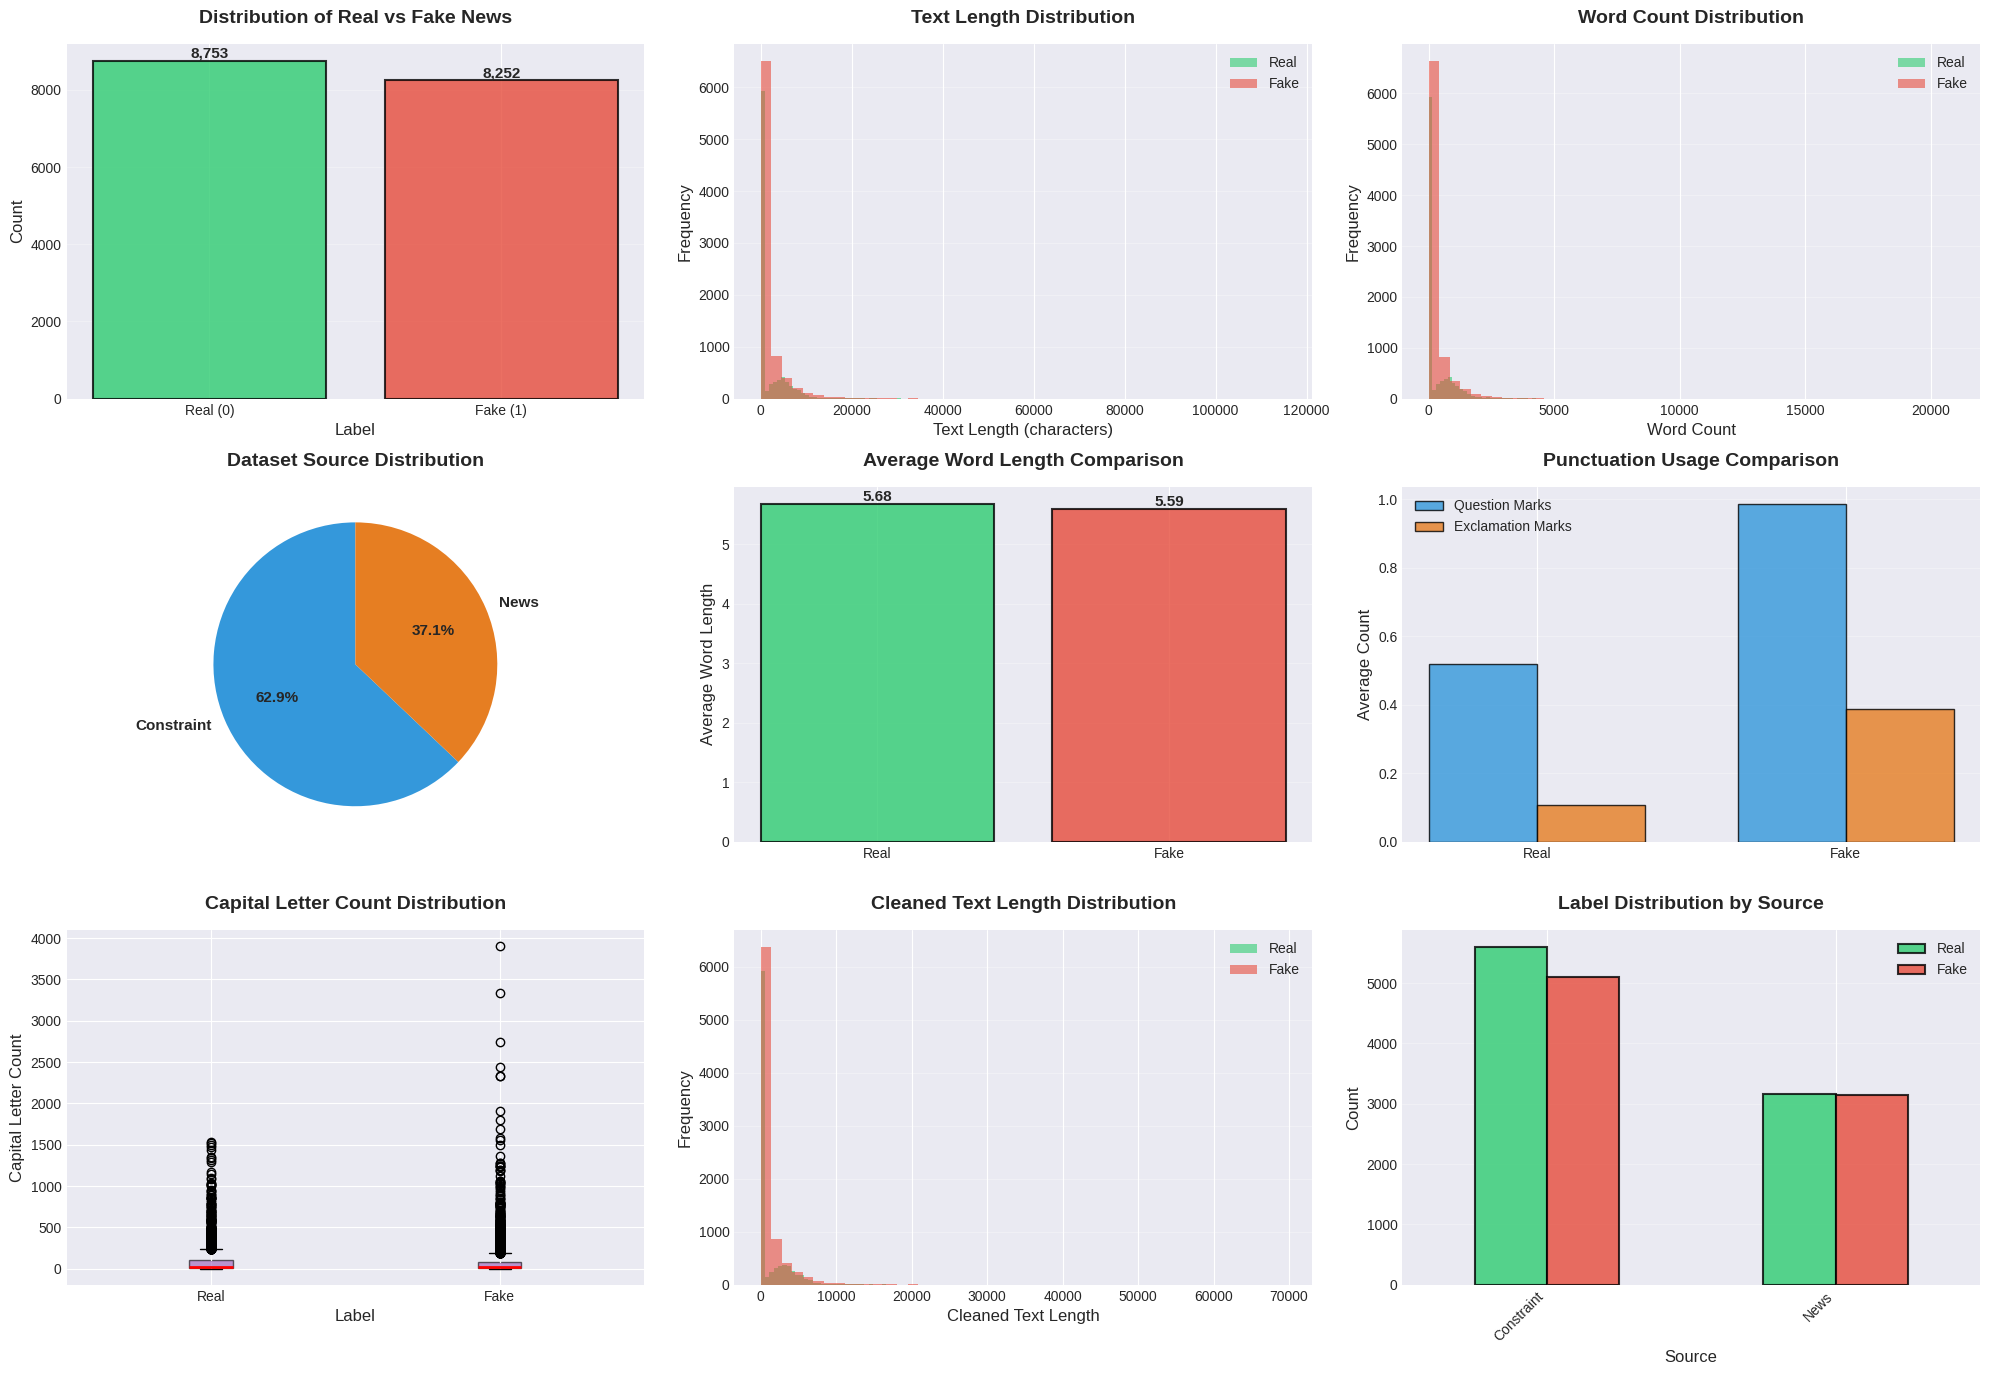


[SUCCESS] EDA visualizations created and saved

STATISTICAL SUMMARY BY LABEL
       text_length                           word_count                  \
              mean          std min     max        mean         std min   
label                                                                     
0      2069.234662  3598.004342  34   44164  338.826003  596.988353   3   
1      1688.930926  4029.970269  14  115448  276.964009  676.907986   3   

             avg_word_length            ... capital_count        \
         max            mean       std  ...           min   max   
label                                   ...                       
0       7626        5.684578  1.066144  ...             0  1530   
1      20904        5.590767  1.238191  ...             0  3904   

      question_marks                    exclamation_marks                     
                mean       std min  max              mean       std min  max  
label                                               

In [18]:
# ============================================================================
# STEP 7: EXPLORATORY DATA ANALYSIS AND VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80)

# Set visualization style for consistent, professional appearance
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create comprehensive visualization with multiple subplots
fig = plt.figure(figsize=(20, 14))

# Plot 1: Label Distribution
print("\n[INFO] Creating visualizations...")
ax1 = plt.subplot(3, 3, 1)
label_counts = master_df['label'].value_counts()
colors = ['#2ecc71', '#e74c3c']
bars = ax1.bar(
    ['Real (0)', 'Fake (1)'],
    label_counts.values,
    color=colors,
    edgecolor='black',
    linewidth=1.5,
    alpha=0.8
)
ax1.set_title('Distribution of Real vs Fake News', fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xlabel('Label', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Add count labels on bars for clarity
for bar in bars:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width()/2.,
        height,
        f'{int(height):,}',
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold'
    )

# Plot 2: Text Length Distribution
ax2 = plt.subplot(3, 3, 2)
master_df[master_df['label'] == 0]['text_length'].hist(
    bins=50, alpha=0.6, label='Real', color='#2ecc71', ax=ax2
)
master_df[master_df['label'] == 1]['text_length'].hist(
    bins=50, alpha=0.6, label='Fake', color='#e74c3c', ax=ax2
)
ax2.set_title('Text Length Distribution', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Text Length (characters)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Word Count Distribution
ax3 = plt.subplot(3, 3, 3)
master_df[master_df['label'] == 0]['word_count'].hist(
    bins=50, alpha=0.6, label='Real', color='#2ecc71', ax=ax3
)
master_df[master_df['label'] == 1]['word_count'].hist(
    bins=50, alpha=0.6, label='Fake', color='#e74c3c', ax=ax3
)
ax3.set_title('Word Count Distribution', fontsize=14, fontweight='bold', pad=15)
ax3.set_xlabel('Word Count', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.legend(loc='upper right')
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Dataset Source Distribution
ax4 = plt.subplot(3, 3, 4)
source_counts = master_df['source'].value_counts()
colors_pie = ['#3498db', '#e67e22']
wedges, texts, autotexts = ax4.pie(
    source_counts.values,
    labels=source_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors_pie,
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)
ax4.set_title('Dataset Source Distribution', fontsize=14, fontweight='bold', pad=15)

# Plot 5: Average Word Length Comparison
ax5 = plt.subplot(3, 3, 5)
avg_word_length_stats = master_df.groupby('label')['avg_word_length'].mean()
bars = ax5.bar(
    ['Real', 'Fake'],
    avg_word_length_stats.values,
    color=['#2ecc71', '#e74c3c'],
    edgecolor='black',
    linewidth=1.5,
    alpha=0.8
)
ax5.set_title('Average Word Length Comparison', fontsize=14, fontweight='bold', pad=15)
ax5.set_ylabel('Average Word Length', fontsize=12)
ax5.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax5.text(
        bar.get_x() + bar.get_width()/2.,
        height,
        f'{height:.2f}',
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold'
    )

# Plot 6: Punctuation Usage Comparison
ax6 = plt.subplot(3, 3, 6)
punct_stats = master_df.groupby('label')[['question_marks', 'exclamation_marks']].mean()
x = np.arange(2)
width = 0.35
bars1 = ax6.bar(
    x - width/2,
    punct_stats['question_marks'],
    width,
    label='Question Marks',
    color='#3498db',
    edgecolor='black',
    alpha=0.8
)
bars2 = ax6.bar(
    x + width/2,
    punct_stats['exclamation_marks'],
    width,
    label='Exclamation Marks',
    color='#e67e22',
    edgecolor='black',
    alpha=0.8
)
ax6.set_title('Punctuation Usage Comparison', fontsize=14, fontweight='bold', pad=15)
ax6.set_ylabel('Average Count', fontsize=12)
ax6.set_xticks(x)
ax6.set_xticklabels(['Real', 'Fake'])
ax6.legend()
ax6.grid(axis='y', alpha=0.3)

# Plot 7: Capital Letter Count Distribution
ax7 = plt.subplot(3, 3, 7)
master_df.boxplot(
    column='capital_count',
    by='label',
    ax=ax7,
    patch_artist=True,
    boxprops=dict(facecolor='#9b59b6', alpha=0.6),
    medianprops=dict(color='red', linewidth=2)
)
ax7.set_title('Capital Letter Count Distribution', fontsize=14, fontweight='bold', pad=15)
ax7.set_xlabel('Label', fontsize=12)
ax7.set_ylabel('Capital Letter Count', fontsize=12)
ax7.set_xticklabels(['Real', 'Fake'])
plt.suptitle('')

# Plot 8: Cleaned Text Length Distribution
ax8 = plt.subplot(3, 3, 8)
master_df['cleaned_text_length'] = master_df['cleaned_text'].str.len()
master_df[master_df['label'] == 0]['cleaned_text_length'].hist(
    bins=50, alpha=0.6, label='Real', color='#2ecc71', ax=ax8
)
master_df[master_df['label'] == 1]['cleaned_text_length'].hist(
    bins=50, alpha=0.6, label='Fake', color='#e74c3c', ax=ax8
)
ax8.set_title('Cleaned Text Length Distribution', fontsize=14, fontweight='bold', pad=15)
ax8.set_xlabel('Cleaned Text Length', fontsize=12)
ax8.set_ylabel('Frequency', fontsize=12)
ax8.legend()
ax8.grid(axis='y', alpha=0.3)

# Plot 9: Label Distribution by Source
ax9 = plt.subplot(3, 3, 9)
source_label_counts = pd.crosstab(master_df['source'], master_df['label'])
source_label_counts.plot(
    kind='bar',
    ax=ax9,
    color=['#2ecc71', '#e74c3c'],
    edgecolor='black',
    linewidth=1.5,
    alpha=0.8
)
ax9.set_title('Label Distribution by Source', fontsize=14, fontweight='bold', pad=15)
ax9.set_xlabel('Source', fontsize=12)
ax9.set_ylabel('Count', fontsize=12)
ax9.set_xticklabels(ax9.get_xticklabels(), rotation=45, ha='right')
ax9.legend(['Real', 'Fake'], loc='upper right')
ax9.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('comprehensive_eda.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n[SUCCESS] EDA visualizations created and saved")

# Print statistical summary
print("\n" + "="*80)
print("STATISTICAL SUMMARY BY LABEL")
print("="*80)
summary_stats = master_df.groupby('label')[[
    'text_length', 'word_count', 'avg_word_length',
    'punctuation_count', 'capital_count', 'question_marks', 'exclamation_marks'
]].agg(['mean', 'std', 'min', 'max'])
print(summary_stats)

print("\n[SUCCESS] Exploratory Data Analysis complete!")


GENERATING WORD CLOUDS
[INFO] Preparing text data for word clouds...
Real news text length: 12,089,081 characters
Fake news text length: 9,258,430 characters

[INFO] Generating word clouds...
[INFO] Creating word cloud for Real news...
[INFO] Creating word cloud for Fake news...


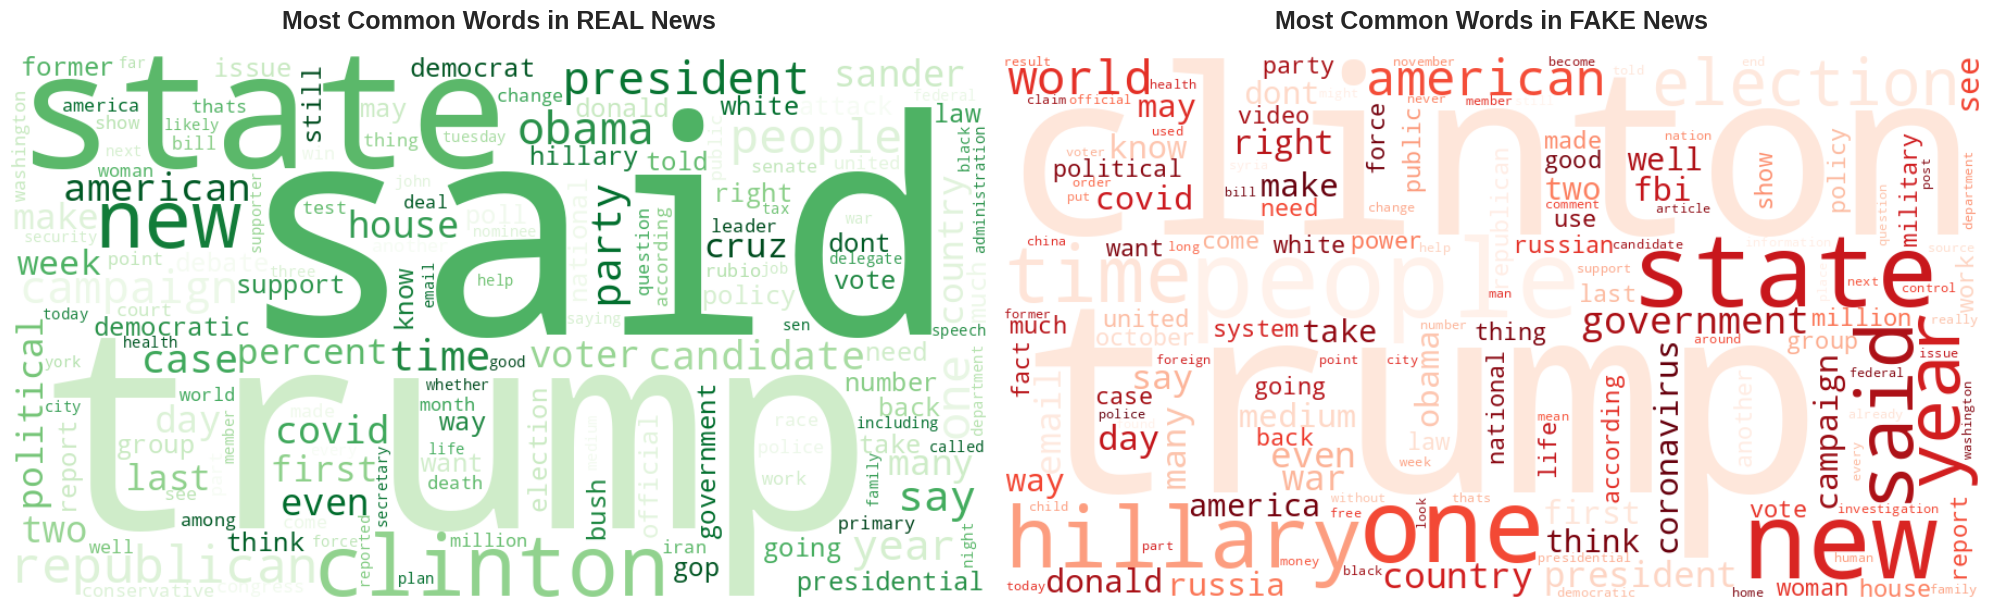


[SUCCESS] Word clouds created and saved


In [19]:
# ============================================================================
# STEP 8: WORD CLOUD GENERATION
# ============================================================================

print("\n" + "="*80)
print("GENERATING WORD CLOUDS")
print("="*80)

# Prepare text data by combining all cleaned texts for each category
print("[INFO] Preparing text data for word clouds...")
real_text = ' '.join(master_df[master_df['label'] == 0]['cleaned_text'].values)
fake_text = ' '.join(master_df[master_df['label'] == 1]['cleaned_text'].values)

print(f"Real news text length: {len(real_text):,} characters")
print(f"Fake news text length: {len(fake_text):,} characters")

# Create word cloud visualizations
print("\n[INFO] Generating word clouds...")
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Word cloud for Real news
print("[INFO] Creating word cloud for Real news...")
wordcloud_real = WordCloud(
    width=900,
    height=500,
    background_color='white',
    colormap='Greens',
    max_words=150,
    relative_scaling=0.5,
    min_font_size=10,
    collocations=False,
    random_state=42
).generate(real_text)

axes[0].imshow(wordcloud_real, interpolation='bilinear')
axes[0].set_title(
    'Most Common Words in REAL News',
    fontsize=18,
    fontweight='bold',
    pad=20
)
axes[0].axis('off')

# Word cloud for Fake news
print("[INFO] Creating word cloud for Fake news...")
wordcloud_fake = WordCloud(
    width=900,
    height=500,
    background_color='white',
    colormap='Reds',
    max_words=150,
    relative_scaling=0.5,
    min_font_size=10,
    collocations=False,
    random_state=42
).generate(fake_text)

axes[1].imshow(wordcloud_fake, interpolation='bilinear')
axes[1].set_title(
    'Most Common Words in FAKE News',
    fontsize=18,
    fontweight='bold',
    pad=20
)
axes[1].axis('off')

plt.tight_layout()
plt.savefig('wordclouds.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n[SUCCESS] Word clouds created and saved")

In [20]:
# ============================================================================
# STEP 9: DATA SPLITTING AND TF-IDF VECTORIZATION
# ============================================================================

print("\n" + "="*80)
print("DATA SPLITTING AND VECTORIZATION")
print("="*80)

# Prepare features (X) and target variable (y)
X = master_df['cleaned_text']
y = master_df['label']

print(f"Total samples: {len(X):,}")
print(f"\nLabel distribution:")
print(y.value_counts())
print(f"\nLabel proportions:")
print(y.value_counts(normalize=True))

# Split data using stratified sampling to maintain class distribution
print("\n[INFO] Splitting data into training and testing sets...")
print("Split ratio: 80% training, 20% testing")
print("Using stratified split to preserve class balance")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\n--- Split Results ---")
print(f"Training set size: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Testing set size: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

print(f"\n--- Training Set Label Distribution ---")
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))

print(f"\n--- Testing Set Label Distribution ---")
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))

# TF-IDF Vectorization to convert text to numerical features
print("\n" + "="*80)
print("TF-IDF VECTORIZATION")
print("="*80)

print("[INFO] Initializing TF-IDF Vectorizer with optimized parameters...")
print("\nVectorizer Parameters:")
print("  - max_features: 5000 (select top 5000 most important features)")
print("  - ngram_range: (1, 2) (capture both single words and two-word combinations)")
print("  - min_df: 2 (word must appear in at least 2 documents)")
print("  - max_df: 0.95 (ignore words appearing in more than 95% of documents)")
print("  - use_idf: True (apply inverse document frequency weighting)")
print("  - smooth_idf: True (prevent division by zero)")
print("  - sublinear_tf: True (apply logarithmic scaling to term frequency)")

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    strip_accents='unicode',
    lowercase=True,
    analyzer='word',
    token_pattern=r'\w{1,}',
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True
)

# Fit vectorizer on training data only to prevent data leakage
print("\n[INFO] Fitting vectorizer on training data...")
X_train_tfidf = vectorizer.fit_transform(X_train)

print("[INFO] Transforming test data...")
X_test_tfidf = vectorizer.transform(X_test)

print(f"\n[SUCCESS] Vectorization complete!")
print(f"\n--- Vectorization Results ---")
print(f"Training TF-IDF matrix shape: {X_train_tfidf.shape}")
print(f"  - Samples: {X_train_tfidf.shape[0]:,}")
print(f"  - Features: {X_train_tfidf.shape[1]:,}")
print(f"\nTesting TF-IDF matrix shape: {X_test_tfidf.shape}")
print(f"  - Samples: {X_test_tfidf.shape[0]:,}")
print(f"  - Features: {X_test_tfidf.shape[1]:,}")
print(f"\nVocabulary size: {len(vectorizer.vocabulary_):,} unique terms")

# Display sample features for reference
feature_names = vectorizer.get_feature_names_out()
print(f"\n--- Sample Features (first 30) ---")
print(list(feature_names[:30]))

print("\n[SUCCESS] Data splitting and vectorization complete!")


DATA SPLITTING AND VECTORIZATION
Total samples: 17,005

Label distribution:
label
0    8753
1    8252
Name: count, dtype: int64

Label proportions:
label
0    0.514731
1    0.485269
Name: proportion, dtype: float64

[INFO] Splitting data into training and testing sets...
Split ratio: 80% training, 20% testing
Using stratified split to preserve class balance

--- Split Results ---
Training set size: 13,604 samples (80.0%)
Testing set size: 3,401 samples (20.0%)

--- Training Set Label Distribution ---
label
0    7002
1    6602
Name: count, dtype: int64
label
0    0.514702
1    0.485298
Name: proportion, dtype: float64

--- Testing Set Label Distribution ---
label
0    1751
1    1650
Name: count, dtype: int64
label
0    0.514849
1    0.485151
Name: proportion, dtype: float64

TF-IDF VECTORIZATION
[INFO] Initializing TF-IDF Vectorizer with optimized parameters...

Vectorizer Parameters:
  - max_features: 5000 (select top 5000 most important features)
  - ngram_range: (1, 2) (capture both


HANDLING CLASS IMBALANCE WITH SMOTE
[INFO] Current training set distribution:
label
0    7002
1    6602
Name: count, dtype: int64

Imbalance ratio: 1.06:1

[INFO] Applying SMOTE to balance the training dataset...
SMOTE (Synthetic Minority Over-sampling Technique) creates synthetic
samples of the minority class to achieve balanced class distribution

SMOTE Parameters:
  - sampling_strategy: 'auto' (minority class will be oversampled to match majority)
  - k_neighbors: 5 (number of nearest neighbors used to generate synthetic samples)
  - random_state: 42 (for reproducible results)

[SUCCESS] SMOTE applied successfully!

--- Resampled Training Set Distribution ---
label
1    7002
0    7002
Name: count, dtype: int64

New balance ratio: 1:1 (Perfect balance achieved)

--- Shape Changes ---
Original training set: (13604, 5000)
Resampled training set: (14004, 5000)
Synthetic samples generated: 400

[INFO] Creating SMOTE effect visualization...


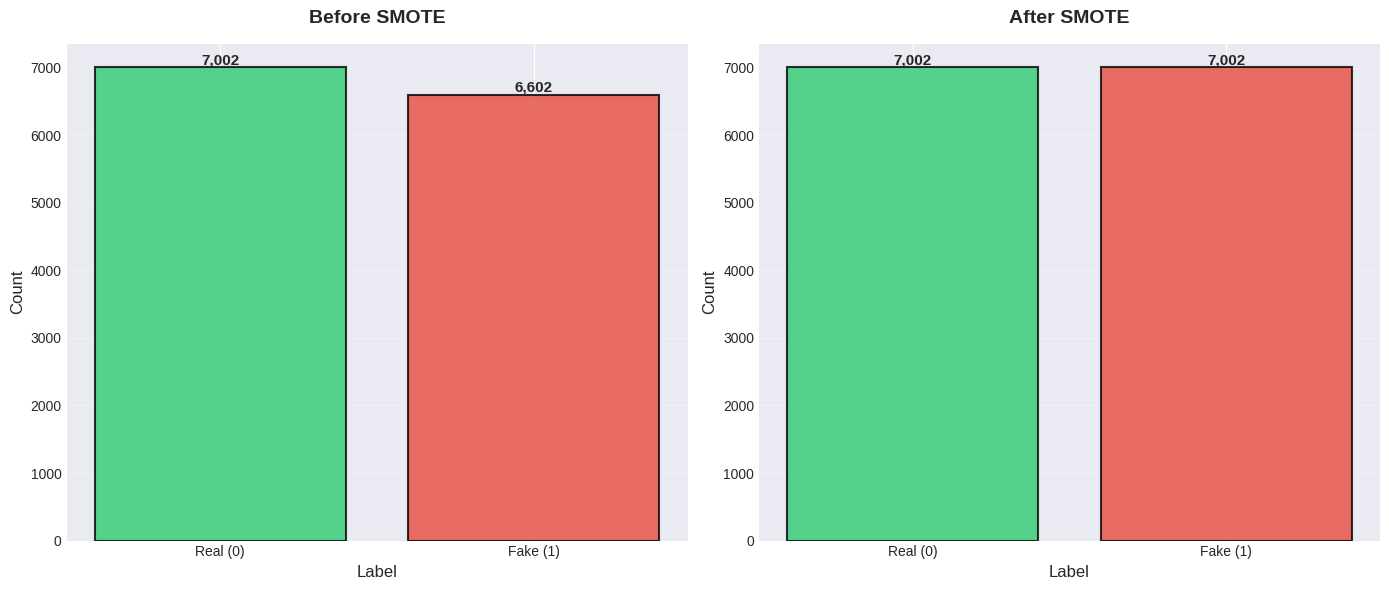


[SUCCESS] SMOTE visualization saved
[SUCCESS] Class imbalance handling complete!


In [21]:
# ============================================================================
# STEP 10: HANDLING CLASS IMBALANCE WITH SMOTE
# ============================================================================

print("\n" + "="*80)
print("HANDLING CLASS IMBALANCE WITH SMOTE")
print("="*80)

# Check current class distribution
print("[INFO] Current training set distribution:")
print(y_train.value_counts())

imbalance_ratio = y_train.value_counts().max() / y_train.value_counts().min()
print(f"\nImbalance ratio: {imbalance_ratio:.2f}:1")

# Apply SMOTE only to training data to avoid data leakage
print("\n[INFO] Applying SMOTE to balance the training dataset...")
print("SMOTE (Synthetic Minority Over-sampling Technique) creates synthetic")
print("samples of the minority class to achieve balanced class distribution")
print("\nSMOTE Parameters:")
print("  - sampling_strategy: 'auto' (minority class will be oversampled to match majority)")
print("  - k_neighbors: 5 (number of nearest neighbors used to generate synthetic samples)")
print("  - random_state: 42 (for reproducible results)")

smote = SMOTE(
    sampling_strategy='auto',
    k_neighbors=5,
    random_state=42
)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

print(f"\n[SUCCESS] SMOTE applied successfully!")
print(f"\n--- Resampled Training Set Distribution ---")
print(pd.Series(y_train_resampled).value_counts())
print(f"\nNew balance ratio: 1:1 (Perfect balance achieved)")
print(f"\n--- Shape Changes ---")
print(f"Original training set: {X_train_tfidf.shape}")
print(f"Resampled training set: {X_train_resampled.shape}")
print(f"Synthetic samples generated: {X_train_resampled.shape[0] - X_train_tfidf.shape[0]:,}")

# Visualize the effect of SMOTE
print("\n[INFO] Creating SMOTE effect visualization...")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Before SMOTE
before_counts = y_train.value_counts().sort_index()
bars1 = axes[0].bar(
    ['Real (0)', 'Fake (1)'],
    before_counts.values,
    color=['#2ecc71', '#e74c3c'],
    edgecolor='black',
    linewidth=1.5,
    alpha=0.8
)
axes[0].set_title('Before SMOTE', fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xlabel('Label', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars1):
    height = bar.get_height()
    axes[0].text(
        bar.get_x() + bar.get_width()/2.,
        height,
        f'{int(height):,}',
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold'
    )

# After SMOTE
after_counts = pd.Series(y_train_resampled).value_counts().sort_index()
bars2 = axes[1].bar(
    ['Real (0)', 'Fake (1)'],
    after_counts.values,
    color=['#2ecc71', '#e74c3c'],
    edgecolor='black',
    linewidth=1.5,
    alpha=0.8
)
axes[1].set_title('After SMOTE', fontsize=14, fontweight='bold', pad=15)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_xlabel('Label', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars2):
    height = bar.get_height()
    axes[1].text(
        bar.get_x() + bar.get_width()/2.,
        height,
        f'{int(height):,}',
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold'
    )

plt.tight_layout()
plt.savefig('smote_effect.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n[SUCCESS] SMOTE visualization saved")
print("[SUCCESS] Class imbalance handling complete!")

In [22]:
# ============================================================================
# STEP 11: TRAIN CALIBRATED CLASSIFICATION MODELS
# ============================================================================

print("\n" + "="*80)
print("TRAINING CALIBRATED CLASSIFICATION MODELS")
print("="*80)

print("[INFO] Using probability calibration to improve model reliability")
print("Calibration adjusts predicted probabilities to better match actual outcomes")

# Define models with calibration wrappers
calibrated_models_dict = {
    "Logistic Regression": CalibratedClassifierCV(
        LogisticRegression(
            random_state=42,
            max_iter=1000,
            C=0.5,
            solver='liblinear',
            class_weight='balanced'
        ),
        cv=5,
        method='sigmoid'
    ),

    "Multinomial Naive Bayes": CalibratedClassifierCV(
        MultinomialNB(alpha=1.0),
        cv=5,
        method='sigmoid'
    ),

    "Support Vector Machine": CalibratedClassifierCV(
        SVC(
            kernel='linear',
            random_state=42,
            C=0.5,
            class_weight='balanced'
        ),
        cv=5,
        method='sigmoid'
    ),

    "Random Forest": CalibratedClassifierCV(
        RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            max_depth=15,
            min_samples_split=10,
            min_samples_leaf=4,
            class_weight='balanced',
            n_jobs=-1
        ),
        cv=5,
        method='sigmoid'
    ),

    "Gradient Boosting": CalibratedClassifierCV(
        GradientBoostingClassifier(
            n_estimators=150,
            random_state=42,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.7,
            min_samples_split=10
        ),
        cv=5,
        method='sigmoid'
    )
}

# Storage for results
classification_results = {}
trained_models = {}
predictions_dict = {}

print(f"\n[INFO] Training {len(calibrated_models_dict)} classification models...")
print("This process may take 10-15 minutes depending on system resources...\n")

# Train each model
for idx, (model_name, model) in enumerate(calibrated_models_dict.items(), 1):
    print(f"\n{'='*70}")
    print(f"[{idx}/{len(calibrated_models_dict)}] Training: {model_name}")
    print(f"{'='*70}")

    # Train the model
    print(f"[INFO] Fitting and calibrating {model_name}...")
    model.fit(X_train_resampled, y_train_resampled)

    # Make predictions
    print(f"[INFO] Generating predictions on test data...")
    y_pred = model.predict(X_test_tfidf)

    # Calculate overall metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Calculate per-class metrics for detailed analysis
    precision_real = precision_score(y_test, y_pred, pos_label=0)
    precision_fake = precision_score(y_test, y_pred, pos_label=1)
    recall_real = recall_score(y_test, y_pred, pos_label=0)
    recall_fake = recall_score(y_test, y_pred, pos_label=1)

    # Store results
    classification_results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Precision (Real)': precision_real,
        'Precision (Fake)': precision_fake,
        'Recall (Real)': recall_real,
        'Recall (Fake)': recall_fake
    }

    trained_models[model_name] = model
    predictions_dict[model_name] = y_pred

    # Display results
    print(f"\n[RESULTS] {model_name}:")
    print(f"  Overall Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

    print(f"\n  Performance by Class:")
    print(f"    Real News - Precision: {precision_real:.4f}, Recall: {recall_real:.4f}")
    print(f"    Fake News - Precision: {precision_fake:.4f}, Recall: {recall_fake:.4f}")

# Create results comparison dataframe
results_df = pd.DataFrame(classification_results).T
results_df = results_df.sort_values('F1-Score', ascending=False)

print("\n" + "="*80)
print("CLASSIFICATION MODELS PERFORMANCE COMPARISON")
print("="*80)
print(results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].to_string())

# Identify best model from initial training
best_initial_model_name = results_df['F1-Score'].idxmax()
best_metrics = results_df.loc[best_initial_model_name]

print(f"\n{'='*80}")
print(f"BEST PERFORMING SINGLE MODEL")
print(f"{'='*80}")
print(f"Model: {best_initial_model_name}")
print(f"Accuracy: {best_metrics['Accuracy']:.4f} ({best_metrics['Accuracy']*100:.2f}%)")
print(f"F1-Score: {best_metrics['F1-Score']:.4f}")
print(f"{'='*80}")

print("\n[SUCCESS] Model training complete!")


TRAINING CALIBRATED CLASSIFICATION MODELS
[INFO] Using probability calibration to improve model reliability
Calibration adjusts predicted probabilities to better match actual outcomes

[INFO] Training 5 classification models...
This process may take 10-15 minutes depending on system resources...


[1/5] Training: Logistic Regression
[INFO] Fitting and calibrating Logistic Regression...
[INFO] Generating predictions on test data...

[RESULTS] Logistic Regression:
  Overall Accuracy:  0.8833 (88.33%)
  Precision: 0.8837
  Recall:    0.8833
  F1-Score:  0.8833

  Performance by Class:
    Real News - Precision: 0.8987, Recall: 0.8715
    Fake News - Precision: 0.8679, Recall: 0.8958

[2/5] Training: Multinomial Naive Bayes
[INFO] Fitting and calibrating Multinomial Naive Bayes...
[INFO] Generating predictions on test data...

[RESULTS] Multinomial Naive Bayes:
  Overall Accuracy:  0.8495 (84.95%)
  Precision: 0.8502
  Recall:    0.8495
  F1-Score:  0.8495

  Performance by Class:
    Rea


VISUALIZING CLASSIFICATION MODEL PERFORMANCE
[INFO] Creating model comparison chart...
[INFO] Creating confusion matrices...
[INFO] Creating F1-Score comparison...
[INFO] Creating accuracy vs F1-score scatter plot...
[INFO] Creating precision vs recall scatter plot...


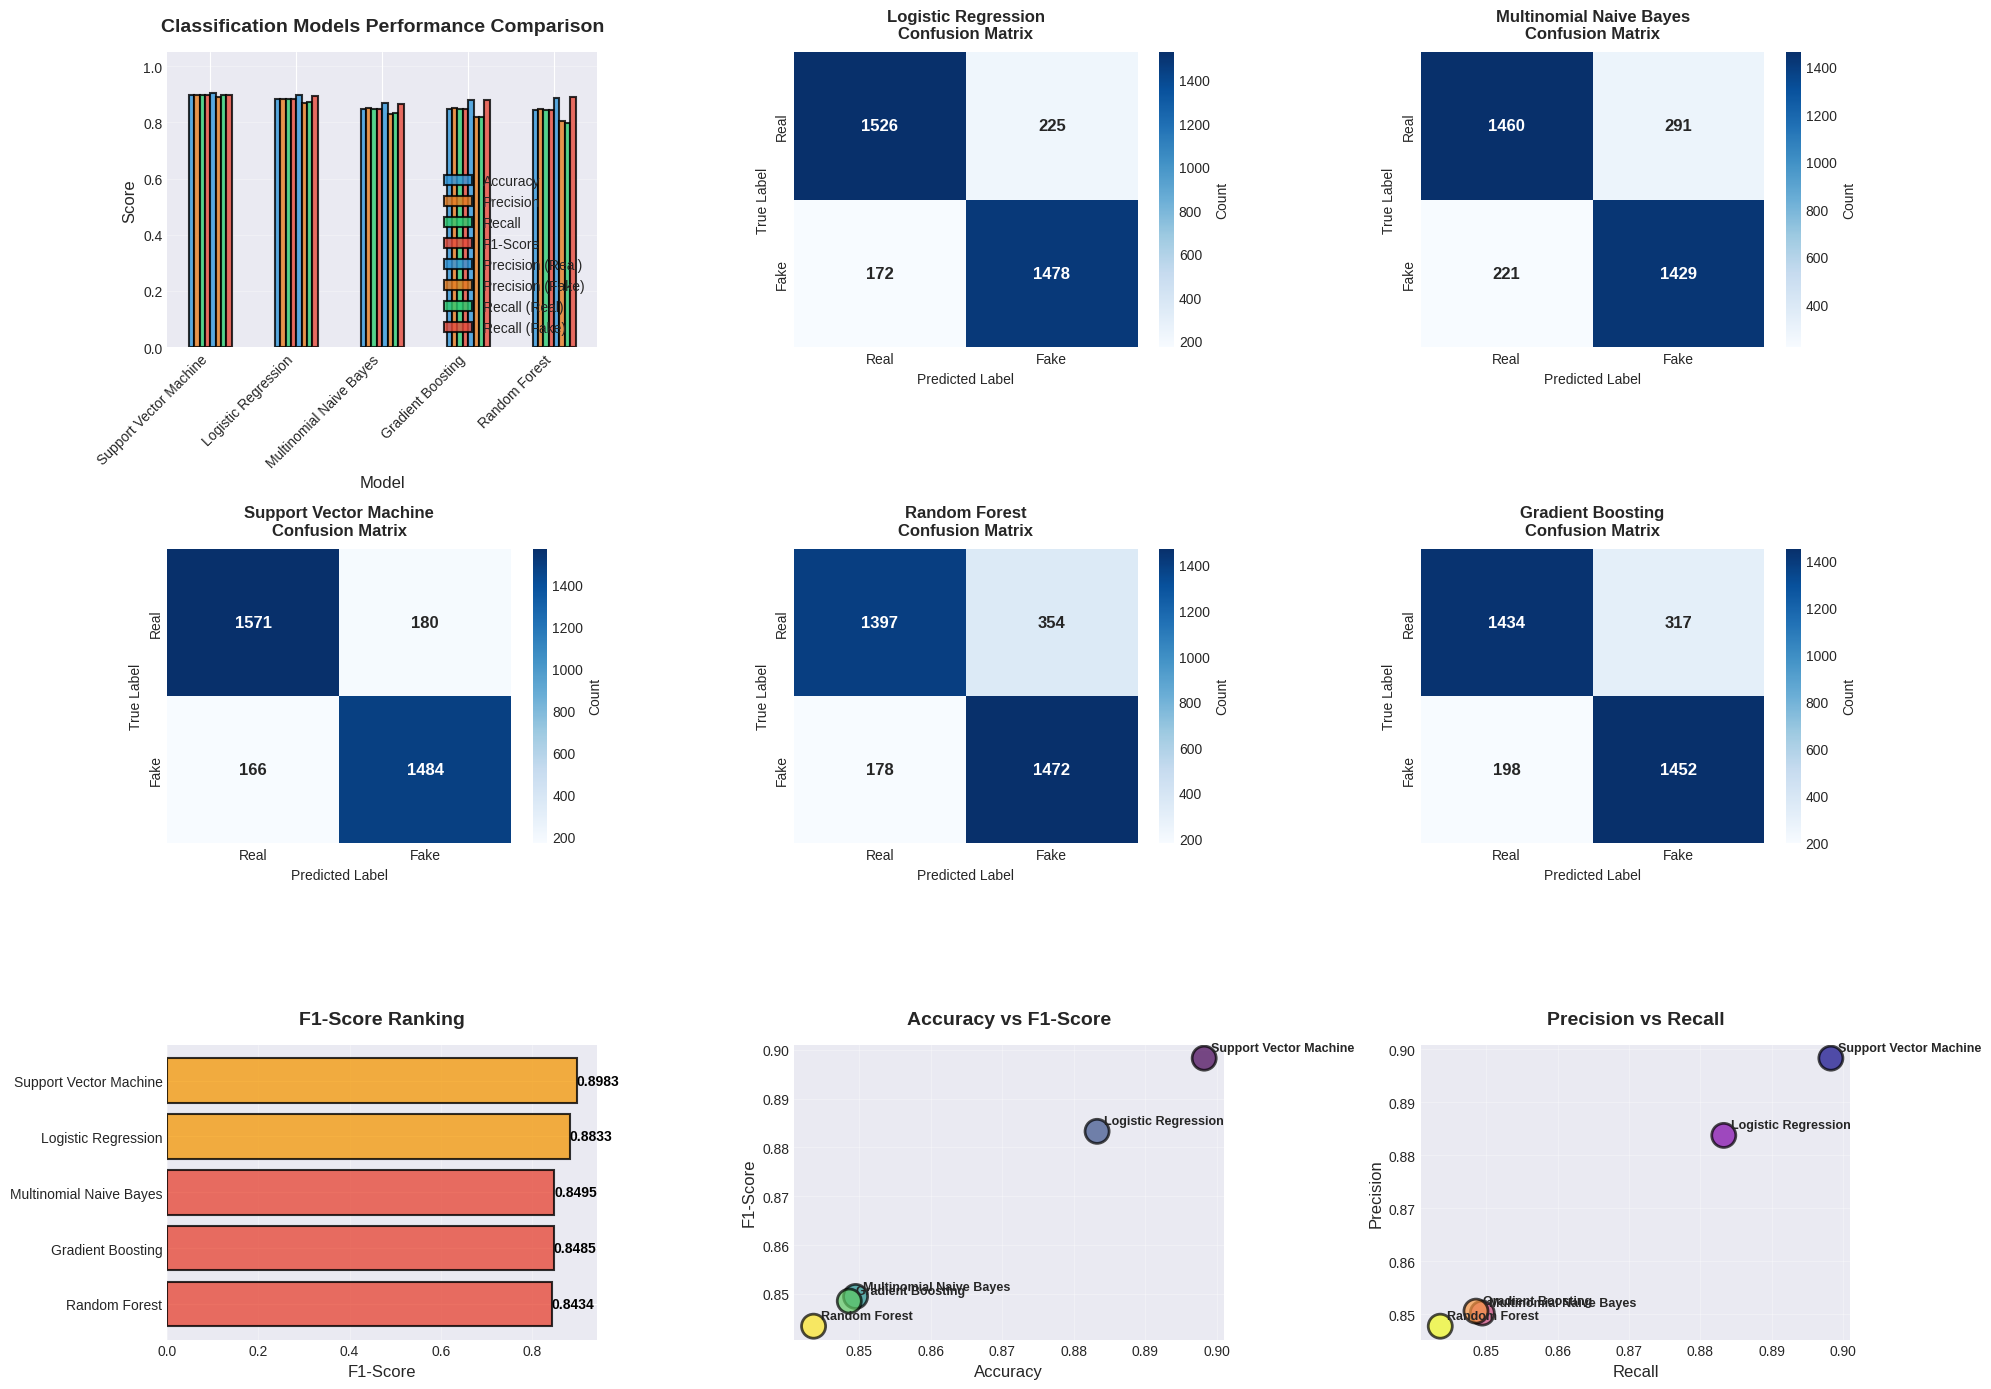


[SUCCESS] Classification performance visualization saved


In [23]:
# ============================================================================
# STEP 12: VISUALIZE CLASSIFICATION MODEL PERFORMANCE
# ============================================================================

print("\n" + "="*80)
print("VISUALIZING CLASSIFICATION MODEL PERFORMANCE")
print("="*80)

# Create comprehensive visualization with multiple subplots
fig = plt.figure(figsize=(20, 14))

# Plot 1: Model Comparison - Bar Chart
print("[INFO] Creating model comparison chart...")
ax1 = plt.subplot(3, 3, 1)
results_df.plot(
    kind='bar',
    ax=ax1,
    color=['#3498db', '#e67e22', '#2ecc71', '#e74c3c'],
    edgecolor='black',
    linewidth=1.5,
    alpha=0.8
)
ax1.set_title('Classification Models Performance Comparison', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_xticklabels(results_df.index, rotation=45, ha='right')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1.05])

# Plots 2-6: Confusion Matrices for each model
print("[INFO] Creating confusion matrices...")
for idx, (model_name, y_pred) in enumerate(predictions_dict.items(), start=2):
    ax = plt.subplot(3, 3, idx)
    cm = confusion_matrix(y_test, y_pred)

    # Create heatmap
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        ax=ax,
        xticklabels=['Real', 'Fake'],
        yticklabels=['Real', 'Fake'],
        cbar_kws={'label': 'Count'},
        annot_kws={'fontsize': 12, 'fontweight': 'bold'}
    )

    ax.set_title(f'{model_name}\nConfusion Matrix', fontsize=12, fontweight='bold', pad=10)
    ax.set_ylabel('True Label', fontsize=10)
    ax.set_xlabel('Predicted Label', fontsize=10)

# Plot 7: F1-Score Ranking
print("[INFO] Creating F1-Score comparison...")
ax7 = plt.subplot(3, 3, 7)
f1_scores = results_df['F1-Score'].sort_values()
colors_f1 = ['#e74c3c' if x < 0.85 else '#f39c12' if x < 0.90 else '#2ecc71' for x in f1_scores.values]
bars = ax7.barh(range(len(f1_scores)), f1_scores.values, color=colors_f1, edgecolor='black', linewidth=1.5, alpha=0.8)
ax7.set_yticks(range(len(f1_scores)))
ax7.set_yticklabels(f1_scores.index)
ax7.set_xlabel('F1-Score', fontsize=12)
ax7.set_title('F1-Score Ranking', fontsize=14, fontweight='bold', pad=15)
ax7.grid(axis='x', alpha=0.3)

for i, bar in enumerate(bars):
    width = bar.get_width()
    ax7.text(width, bar.get_y() + bar.get_height()/2., f'{width:.4f}',
             ha='left', va='center', fontsize=10, fontweight='bold', color='black')

# Plot 8: Accuracy vs F1-Score Scatter
print("[INFO] Creating accuracy vs F1-score scatter plot...")
ax8 = plt.subplot(3, 3, 8)
scatter = ax8.scatter(
    results_df['Accuracy'],
    results_df['F1-Score'],
    s=300,
    c=range(len(results_df)),
    cmap='viridis',
    edgecolors='black',
    linewidth=2,
    alpha=0.7
)
ax8.set_xlabel('Accuracy', fontsize=12)
ax8.set_ylabel('F1-Score', fontsize=12)
ax8.set_title('Accuracy vs F1-Score', fontsize=14, fontweight='bold', pad=15)
ax8.grid(True, alpha=0.3)

# Add model name labels to scatter points
for idx, (model_name, row) in enumerate(results_df.iterrows()):
    ax8.annotate(
        model_name,
        (row['Accuracy'], row['F1-Score']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9,
        fontweight='bold'
    )

# Plot 9: Precision vs Recall
print("[INFO] Creating precision vs recall scatter plot...")
ax9 = plt.subplot(3, 3, 9)
scatter2 = ax9.scatter(
    results_df['Recall'],
    results_df['Precision'],
    s=300,
    c=range(len(results_df)),
    cmap='plasma',
    edgecolors='black',
    linewidth=2,
    alpha=0.7
)
ax9.set_xlabel('Recall', fontsize=12)
ax9.set_ylabel('Precision', fontsize=12)
ax9.set_title('Precision vs Recall', fontsize=14, fontweight='bold', pad=15)
ax9.grid(True, alpha=0.3)

# Add model name labels
for idx, (model_name, row) in enumerate(results_df.iterrows()):
    ax9.annotate(
        model_name,
        (row['Recall'], row['Precision']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9,
        fontweight='bold'
    )

plt.tight_layout()
plt.savefig('classification_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n[SUCCESS] Classification performance visualization saved")


CLUSTERING ANALYSIS WITH K-MEANS
[INFO] Applying PCA for dimensionality reduction...
Reducing from 5000 TF-IDF features to 50 principal components

[SUCCESS] PCA applied successfully!
Components: 50
Explained variance ratio: 0.2019 (20.19%)

[INFO] Applying K-Means clustering...
Parameters:
  - n_clusters: 2 (attempting to separate Real vs Fake)
  - n_init: 10 (number of times algorithm runs with different seeds)
  - max_iter: 300 (maximum iterations per run)
  - random_state: 42 (for reproducibility)

[SUCCESS] K-Means clustering complete!

CLUSTER ANALYSIS

--- Training Data - Cluster Distribution ---
Cluster        0     1
True Label            
0           2321  4681
1           2211  4791

--- Testing Data - Cluster Distribution ---
Cluster       0     1
True Label           
0           570  1181
1           500  1150

--- Clustering Purity Scores ---
Training Cluster Purity: 0.5079 (50.79%)
Testing Cluster Purity: 0.5148 (51.48%)

[INFO] Creating cluster visualizations...
2D PC

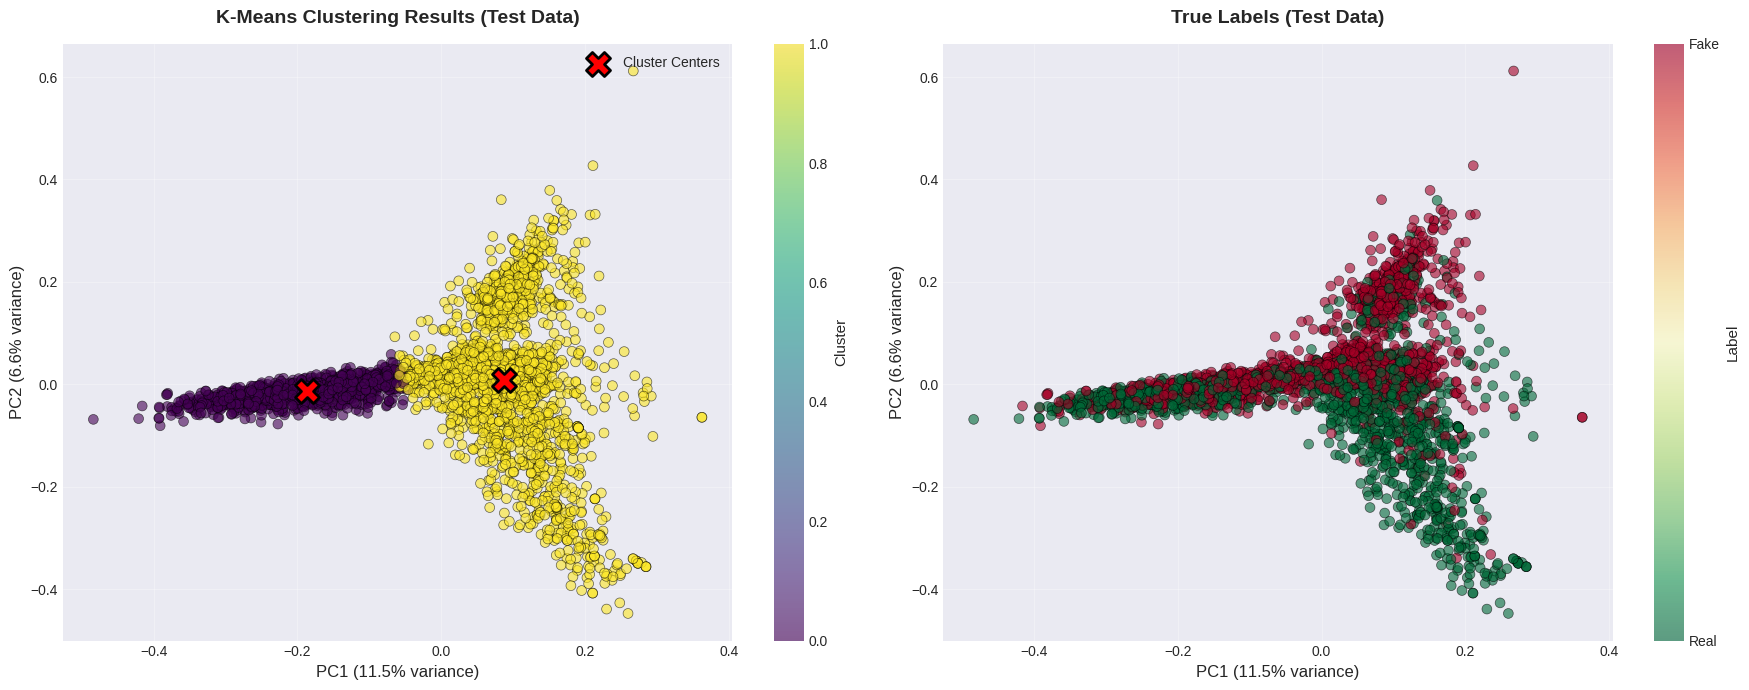


[SUCCESS] Clustering visualization saved
[SUCCESS] Clustering analysis complete!


In [24]:
# ============================================================================
# STEP 13: CLUSTERING ANALYSIS WITH K-MEANS
# ============================================================================

print("\n" + "="*80)
print("CLUSTERING ANALYSIS WITH K-MEANS")
print("="*80)

# Apply PCA for dimensionality reduction before clustering
print("[INFO] Applying PCA for dimensionality reduction...")
print("Reducing from 5000 TF-IDF features to 50 principal components")

pca = PCA(n_components=50, random_state=42)
X_train_pca = pca.fit_transform(X_train_resampled.toarray())
X_test_pca = pca.transform(X_test_tfidf.toarray())

explained_variance = pca.explained_variance_ratio_.sum()
print(f"\n[SUCCESS] PCA applied successfully!")
print(f"Components: {pca.n_components_}")
print(f"Explained variance ratio: {explained_variance:.4f} ({explained_variance*100:.2f}%)")

# Apply K-Means clustering
print("\n[INFO] Applying K-Means clustering...")
print("Parameters:")
print("  - n_clusters: 2 (attempting to separate Real vs Fake)")
print("  - n_init: 10 (number of times algorithm runs with different seeds)")
print("  - max_iter: 300 (maximum iterations per run)")
print("  - random_state: 42 (for reproducibility)")

kmeans = KMeans(
    n_clusters=2,
    random_state=42,
    n_init=10,
    max_iter=300
)

kmeans_train_clusters = kmeans.fit_predict(X_train_pca)
kmeans_test_clusters = kmeans.predict(X_test_pca)

print(f"\n[SUCCESS] K-Means clustering complete!")

# Analyze cluster purity
print("\n" + "="*80)
print("CLUSTER ANALYSIS")
print("="*80)

# Training data cluster distribution
train_cluster_df = pd.DataFrame({
    'True_Label': y_train_resampled,
    'Cluster': kmeans_train_clusters
})

print("\n--- Training Data - Cluster Distribution ---")
train_crosstab = pd.crosstab(
    train_cluster_df['True_Label'],
    train_cluster_df['Cluster'],
    rownames=['True Label'],
    colnames=['Cluster']
)
print(train_crosstab)

# Testing data cluster distribution
test_cluster_df = pd.DataFrame({
    'True_Label': y_test,
    'Cluster': kmeans_test_clusters
})

print("\n--- Testing Data - Cluster Distribution ---")
test_crosstab = pd.crosstab(
    test_cluster_df['True_Label'],
    test_cluster_df['Cluster'],
    rownames=['True Label'],
    colnames=['Cluster']
)
print(test_crosstab)

# Calculate clustering purity
def calculate_purity(true_labels, cluster_labels):

    contingency_matrix = pd.crosstab(true_labels, cluster_labels)
    return np.sum(np.amax(contingency_matrix.values, axis=0)) / np.sum(contingency_matrix.values)

train_purity = calculate_purity(y_train_resampled, kmeans_train_clusters)
test_purity = calculate_purity(y_test, kmeans_test_clusters)

print(f"\n--- Clustering Purity Scores ---")
print(f"Training Cluster Purity: {train_purity:.4f} ({train_purity*100:.2f}%)")
print(f"Testing Cluster Purity: {test_purity:.4f} ({test_purity*100:.2f}%)")

# Visualize clusters in 2D space
print("\n[INFO] Creating cluster visualizations...")

# Further reduce to 2D for visualization
pca_2d = PCA(n_components=2, random_state=42)
X_test_2d = pca_2d.fit_transform(X_test_pca)

explained_var_2d = pca_2d.explained_variance_ratio_
print(f"2D PCA explained variance: {explained_var_2d.sum():.4f}")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: K-Means Clusters
scatter1 = axes[0].scatter(
    X_test_2d[:, 0],
    X_test_2d[:, 1],
    c=kmeans_test_clusters,
    cmap='viridis',
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5,
    s=50
)
axes[0].set_title(
    'K-Means Clustering Results (Test Data)',
    fontsize=14,
    fontweight='bold',
    pad=15
)
axes[0].set_xlabel(f'PC1 ({explained_var_2d[0]*100:.1f}% variance)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({explained_var_2d[1]*100:.1f}% variance)', fontsize=12)
axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Cluster', fontsize=11)

# Plot cluster centers
centers_2d = pca_2d.transform(kmeans.cluster_centers_)
axes[0].scatter(
    centers_2d[:, 0],
    centers_2d[:, 1],
    c='red',
    marker='X',
    s=300,
    edgecolors='black',
    linewidth=2,
    label='Cluster Centers'
)
axes[0].legend(loc='upper right', fontsize=10)

# Plot 2: True Labels
scatter2 = axes[1].scatter(
    X_test_2d[:, 0],
    X_test_2d[:, 1],
    c=y_test,
    cmap='RdYlGn_r',
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5,
    s=50
)
axes[1].set_title(
    'True Labels (Test Data)',
    fontsize=14,
    fontweight='bold',
    pad=15
)
axes[1].set_xlabel(f'PC1 ({explained_var_2d[0]*100:.1f}% variance)', fontsize=12)
axes[1].set_ylabel(f'PC2 ({explained_var_2d[1]*100:.1f}% variance)', fontsize=12)
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1], ticks=[0, 1])
cbar2.set_label('Label', fontsize=11)
cbar2.ax.set_yticklabels(['Real', 'Fake'])

plt.tight_layout()
plt.savefig('clustering_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n[SUCCESS] Clustering visualization saved")
print("[SUCCESS] Clustering analysis complete!")

In [25]:
# ============================================================================
# STEP 14: BALANCED ENSEMBLE MODEL
# ============================================================================

print("\n" + "="*80)
print("CREATING BALANCED ENSEMBLE MODEL")
print("="*80)

print("[INFO] Creating ensemble with calibrated base models")
print("Ensemble voting strategy: Soft (uses predicted probabilities)")

# Create balanced ensemble with top performing algorithms
balanced_ensemble = VotingClassifier(
    estimators=[
        ('lr_cal', CalibratedClassifierCV(
            LogisticRegression(random_state=42, max_iter=1000, C=0.5, class_weight='balanced'),
            cv=5, method='sigmoid'
        )),
        ('rf_cal', CalibratedClassifierCV(
            RandomForestClassifier(n_estimators=200, random_state=42, max_depth=15,
                                  min_samples_split=10, class_weight='balanced', n_jobs=-1),
            cv=5, method='sigmoid'
        )),
        ('gb_cal', CalibratedClassifierCV(
            GradientBoostingClassifier(n_estimators=150, random_state=42,
                                      learning_rate=0.05, max_depth=4, subsample=0.7),
            cv=5, method='sigmoid'
        ))
    ],
    voting='soft',
    n_jobs=-1
)

print("\n[INFO] Training balanced ensemble model...")
print("This may take a few minutes...")
balanced_ensemble.fit(X_train_resampled, y_train_resampled)

# Test the ensemble
balanced_ensemble_pred = balanced_ensemble.predict(X_test_tfidf)

# Calculate metrics
balanced_accuracy = accuracy_score(y_test, balanced_ensemble_pred)
balanced_f1 = f1_score(y_test, balanced_ensemble_pred, average='weighted')
balanced_precision_real = precision_score(y_test, balanced_ensemble_pred, pos_label=0)
balanced_precision_fake = precision_score(y_test, balanced_ensemble_pred, pos_label=1)
balanced_recall_real = recall_score(y_test, balanced_ensemble_pred, pos_label=0)
balanced_recall_fake = recall_score(y_test, balanced_ensemble_pred, pos_label=1)

print(f"\n[RESULTS] Balanced Ensemble Performance:")
print(f"  Overall Accuracy:  {balanced_accuracy:.4f} ({balanced_accuracy*100:.2f}%)")
print(f"  F1-Score:  {balanced_f1:.4f}")
print(f"\n  Performance by Class:")
print(f"    Real News - Precision: {balanced_precision_real:.4f}, Recall: {balanced_recall_real:.4f}")
print(f"    Fake News - Precision: {balanced_precision_fake:.4f}, Recall: {balanced_recall_fake:.4f}")

# Add ensemble to results
classification_results['Ensemble (Balanced)'] = {
    'Accuracy': balanced_accuracy,
    'Precision': (balanced_precision_real + balanced_precision_fake) / 2,
    'Recall': (balanced_recall_real + balanced_recall_fake) / 2,
    'F1-Score': balanced_f1
}

trained_models['Ensemble (Balanced)'] = balanced_ensemble

# Update best model to ensemble
best_model = balanced_ensemble
best_model_name = "Ensemble (Balanced)"

print("\n[SUCCESS] Balanced ensemble created and evaluated!")
print(f"[INFO] Best model set to: {best_model_name}")


CREATING BALANCED ENSEMBLE MODEL
[INFO] Creating ensemble with calibrated base models
Ensemble voting strategy: Soft (uses predicted probabilities)

[INFO] Training balanced ensemble model...
This may take a few minutes...

[RESULTS] Balanced Ensemble Performance:
  Overall Accuracy:  0.8695 (86.95%)
  F1-Score:  0.8694

  Performance by Class:
    Real News - Precision: 0.8982, Recall: 0.8418
    Fake News - Precision: 0.8426, Recall: 0.8988

[SUCCESS] Balanced ensemble created and evaluated!
[INFO] Best model set to: Ensemble (Balanced)


In [26]:
# ============================================================================
# STEP 15: SAVE BEST MODEL AND ARTIFACTS
# ============================================================================

print("\n" + "="*80)
print("SAVING MODELS AND ARTIFACTS")
print("="*80)

# Save the best model
model_filename = 'best_misinfo_detection_model.joblib'
print(f"\n[INFO] Saving best model: {best_model_name}")
joblib.dump(best_model, model_filename)
print(f"[SUCCESS] Model saved as: {model_filename}")

# Save the TF-IDF vectorizer
vectorizer_filename = 'tfidf_vectorizer.joblib'
print(f"\n[INFO] Saving TF-IDF vectorizer...")
joblib.dump(vectorizer, vectorizer_filename)
print(f"[SUCCESS] Vectorizer saved as: {vectorizer_filename}")

# Save model metadata
metadata = {
    'model_name': best_model_name,
    'model_type': type(best_model).__name__,
    'performance_metrics': {
        'accuracy': float(balanced_accuracy),
        'f1_score': float(balanced_f1)
    },
    'dataset_info': {
        'total_samples': len(master_df),
        'training_samples': X_train_resampled.shape[0],
        'testing_samples': len(X_test),
        'real_samples': int((master_df['label'] == 0).sum()),
        'fake_samples': int((master_df['label'] == 1).sum())
    },
    'feature_extraction': {
        'method': 'TF-IDF',
        'max_features': 5000,
        'ngram_range': '(1, 2)',
        'vocabulary_size': len(vectorizer.vocabulary_)
    }
}

metadata_filename = 'model_metadata.joblib'
print(f"\n[INFO] Saving model metadata...")
joblib.dump(metadata, metadata_filename)
print(f"[SUCCESS] Metadata saved as: {metadata_filename}")

# Save final results
final_results_df = pd.DataFrame(classification_results).T
results_filename = 'model_comparison_results.csv'
final_results_df.to_csv(results_filename)
print(f"[SUCCESS] Results saved as: {results_filename}")

# Save processed dataset
processed_data_filename = 'processed_dataset.csv'
print(f"\n[INFO] Saving processed dataset...")
master_df.to_csv(processed_data_filename, index=False)
print(f"[SUCCESS] Processed dataset saved as: {processed_data_filename}")

print("\n[SUCCESS] All models and artifacts saved successfully!")


SAVING MODELS AND ARTIFACTS

[INFO] Saving best model: Ensemble (Balanced)
[SUCCESS] Model saved as: best_misinfo_detection_model.joblib

[INFO] Saving TF-IDF vectorizer...
[SUCCESS] Vectorizer saved as: tfidf_vectorizer.joblib

[INFO] Saving model metadata...
[SUCCESS] Metadata saved as: model_metadata.joblib
[SUCCESS] Results saved as: model_comparison_results.csv

[INFO] Saving processed dataset...
[SUCCESS] Processed dataset saved as: processed_dataset.csv

[SUCCESS] All models and artifacts saved successfully!


In [28]:
# ============================================================================
# STEP 16: INTERACTIVE PREDICTION SYSTEM
# ============================================================================

print("\n" + "="*80)
print("INTERACTIVE MISINFORMATION DETECTION SYSTEM")
print("="*80)

def predict_with_threshold(text, model, vectorizer, threshold=0.55):

    # Clean the input text
    cleaned = advanced_text_cleaning(text)

    if not cleaned or len(cleaned.strip()) == 0:
        return {
            'status': 'error',
            'message': 'No meaningful content found after cleaning. Please provide more text.'
        }

    # Vectorize the cleaned text
    text_tfidf = vectorizer.transform([cleaned])

    # Get probabilities
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(text_tfidf)[0]
        prob_real = probabilities[0]
        prob_fake = probabilities[1]

        # Apply custom threshold to reduce fake bias
        if prob_fake >= threshold:
            prediction = 1
            confidence = prob_fake
        else:
            prediction = 0
            confidence = prob_real
    else:
        prediction = model.predict(text_tfidf)[0]
        confidence = 1.0
        prob_real = 1.0 if prediction == 0 else 0.0
        prob_fake = 1.0 if prediction == 1 else 0.0

    # Determine verdict based on confidence levels
    if prediction == 1:
        if confidence >= 0.75:
            verdict = "FAKE NEWS"
            warning_level = "HIGH"
        elif confidence >= threshold:
            verdict = "LIKELY FAKE"
            warning_level = "MEDIUM"
        else:
            verdict = "UNCERTAIN (Leaning Fake)"
            warning_level = "LOW-MEDIUM"
    else:
        if confidence >= 0.75:
            verdict = "REAL NEWS"
            warning_level = "LOW"
        elif confidence >= threshold:
            verdict = "LIKELY REAL"
            warning_level = "LOW-MEDIUM"
        else:
            verdict = "UNCERTAIN (Leaning Real)"
            warning_level = "MEDIUM"

    return {
        'status': 'success',
        'prediction': int(prediction),
        'verdict': verdict,
        'confidence': float(confidence),
        'probability_real': float(prob_real),
        'probability_fake': float(prob_fake),
        'warning_level': warning_level,
        'cleaned_text': cleaned,
        'threshold_used': threshold
    }

# Interactive testing loop with adjustable threshold
print("\n[INFO] Starting Interactive Prediction System...")
print("\nCommands:")
print("  - Type your news text to analyze it")
print("  - Type 'threshold X' to set custom threshold (e.g., 'threshold 0.6')")
print("  - Type 'info' to see current settings")
print("  - Type 'exit' to quit")
print("\n" + "="*80)

current_threshold = 0.55  # Start with slightly higher threshold to reduce fake bias

while True:
    print("\n" + "-"*80)
    print(f"[Current Threshold: {current_threshold:.2f}]")
    print("-"*80)

    user_input = input("\nEnter news text to analyze (or command): ")

    # Check for exit command
    if user_input.lower() == 'exit':
        print("\n[INFO] Exiting detection system. Goodbye!")
        break

    # Check for threshold adjustment
    if user_input.lower().startswith('threshold'):
        try:
            new_threshold = float(user_input.split()[1])
            if 0.3 <= new_threshold <= 0.9:
                current_threshold = new_threshold
                print(f"\n[INFO] Threshold updated to {current_threshold:.2f}")
                print(f"  - Higher threshold = More conservative (fewer false positives)")
                print(f"  - Lower threshold = More sensitive (catches more potential fakes)")
            else:
                print("\n[ERROR] Threshold must be between 0.3 and 0.9")
        except:
            print("\n[ERROR] Invalid format. Use: threshold 0.6")
        continue

    # Check for info command
    if user_input.lower() == 'info':
        print(f"\n[INFO] Current Settings:")
        print(f"  Model: {best_model_name}")
        print(f"  Decision Threshold: {current_threshold:.2f}")
        print(f"  Calibration: Enabled")
        print(f"\n  Threshold Guide:")
        print(f"    0.50 = Balanced (equal treatment)")
        print(f"    0.55 = Slightly favors Real (recommended, default)")
        print(f"    0.60 = Conservative (reduces false fake alerts)")
        print(f"    0.70 = Very conservative")
        continue

    # Validate input
    if not user_input.strip():
        print("\n[ERROR] Please enter some text to analyze.")
        continue

    # Display analysis header
    print("\n" + "="*80)
    print("ANALYSIS RESULTS")
    print("="*80)

    # Make prediction with current threshold
    result = predict_with_threshold(user_input, best_model, vectorizer, current_threshold)

    if result['status'] == 'error':
        print(f"\n[ERROR] {result['message']}")
    else:
        print(f"\nVERDICT: {result['verdict']}")
        print(f"Confidence: {result['confidence']:.2%}")
        print(f"Warning Level: {result['warning_level']}")

        print(f"\nDetailed Probabilities:")
        print(f"  Real News: {result['probability_real']:.2%}")
        print(f"  Fake News: {result['probability_fake']:.2%}")

        # Add interpretation based on probability difference
        prob_diff = abs(result['probability_real'] - result['probability_fake'])
        if prob_diff < 0.15:
            print(f"\n  Note: Probabilities are very close ({prob_diff:.1%} difference)")
            print(f"        Model is uncertain. Consider additional verification.")
        elif result['confidence'] >= 0.85:
            print(f"\n  Note: High confidence prediction ({result['confidence']:.0%} certain)")

        print(f"\nClassification: {'Fake (1)' if result['prediction'] == 1 else 'Real (0)'}")
        print(f"Threshold Used: {result['threshold_used']:.2f}")

        print(f"\nCleaned Text Preview:")
        print(f"  {result['cleaned_text'][:150]}...")

    print("="*80)

print("\n[SUCCESS] Interactive prediction system session ended!")


INTERACTIVE MISINFORMATION DETECTION SYSTEM

[INFO] Starting Interactive Prediction System...

Commands:
  - Type your news text to analyze it
  - Type 'threshold X' to set custom threshold (e.g., 'threshold 0.6')
  - Type 'info' to see current settings
  - Type 'exit' to quit


--------------------------------------------------------------------------------
[Current Threshold: 0.55]
--------------------------------------------------------------------------------

Enter news text to analyze (or command): Could Hillary Clinton be the next Richard Nixon? Now thatâ€™s a provocative question, but it isnâ€™t quite what you think.  The other day, I watched Hillary and Bill Clinton take in their close friend Terry McAuliffeâ€™s inauguration as governor of Virginia. Neither Clinton spoke, but their presence said it all: Virginia, the Mother of Presidents long before it was a modern swing state, will be seeing a lot of the Clintonsâ€”and now they have a ready-made home-away-from-home in the gu